# Data Exploration

To prepare data for training a model, we need to understand the data, prepare annotations files and transform CT scans into vector files we can effectively work with. This notebook focuses on annotation files. We start by trying to understand the data and then we will extract the data we need into one file. The result of this notebook will be a CSV file (`complete_candidates.csv`) that contains all information about nodules we will be classifying and their labels.


In [46]:
import matplotlib.pyplot as plt
import pandas as pd

from luna16 import enums, settings

%matplotlib inline

## Candidates File Exploration

The `candidates.csv` and `candidates_v2.csv` file contains information about all lumps that potentially look like nodules, whether those lumps are malignant, benign tumors, or something else altogether. We’ll use this as the basis for building a complete list of candidates that can then be split into our training and validation datasets.

### The Data

Dataframe contains 754975 rows. 753418 of them are marked as not nodules and 1557 are marked as nodules.

The columns in the `candidates.csv` file are as follows:

- `seriesuid`: The unique identifier for the CT scan in which the nodule was found.
- `coordX`, `coordY`, `coordZ`: The x, y, and z coordinates of the candidate nodule in the CT scan.
- `class`: The classification of the nodule. 0 = no nodule, 1 = nodule

### Class Distribution

From the class distribution, we can see that the dataset is highly imbalanced. We have 549714 candidates with no nodule and 1351 candidates with a nodule. This is a ratio of 406:1. This is a very high imbalance and we will need to address this when we build our model.

### Series UIDs

The `seriesuid` column contains the unique identifier for the CT scan it relates to. We have 888 unique series UIDs in the dataset. This is the number of CT scans we have in the dataset. 

Thus, each CT scam has multiple candidates. It's approximately 850 candidates per CT scan.


In [47]:
candidates_path = settings.DATA_DIR / "candidates.csv"
# because candidates_v2.csv contains more examples that candidates.csv (754975 vs. 551064), we will use candidates_v2.csv
candidates_v2_path = settings.DATA_DIR / "candidates_v2.csv"
candidates = pd.read_csv(filepath_or_buffer=candidates_v2_path)
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754975 entries, 0 to 754974
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  754975 non-null  object 
 1   coordX     754975 non-null  float64
 2   coordY     754975 non-null  float64
 3   coordZ     754975 non-null  float64
 4   class      754975 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 28.8+ MB


In [48]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [49]:
n_is_nodules = len(candidates[candidates["class"] == 1])
n_not_nodules = len(candidates[candidates["class"] == 0])
percentage_of_malignant = (100 * n_is_nodules) / len(candidates)

print(f"LuNA 16 contains {n_is_nodules} nodules and {n_not_nodules} not nodules.")
print(f"Nodules are {percentage_of_malignant:.2f}%.")

candidates["class"].value_counts()

LuNA 16 contains 1557 nodules and 753418 not nodules.
Nodules are 0.21%.


class
0    753418
1      1557
Name: count, dtype: int64

In [50]:
n_candidates = len(candidates)
n_unique_candidates_seriesuids = len(candidates.seriesuid.unique())
print(
    f"Candidates dataframe has {n_candidates} rows and {n_unique_candidates_seriesuids} unique series uid values."
)

Candidates dataframe has 754975 rows and 888 unique series uid values.


In [51]:
series_uid_values_count = candidates["seriesuid"].value_counts()
n_same_seriesuid_mean_for_candidates = series_uid_values_count.mean()
print(
    f"For {len(candidates)} number of candidates, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_candidates:.2f}."
)
series_uid_values_count

For 754975 number of candidates, the average number of rows with same seriesuid is 850.20.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822    2066
1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586    1973
1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295    1828
1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856    1723
1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687    1713
                                                                    ... 
1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320     215
1.3.6.1.4.1.14519.5.2.1.6279.6001.333319057944372470283038483725     208
1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630     207
1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559     185
1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938      66
Name: count, Length: 888, dtype: int64

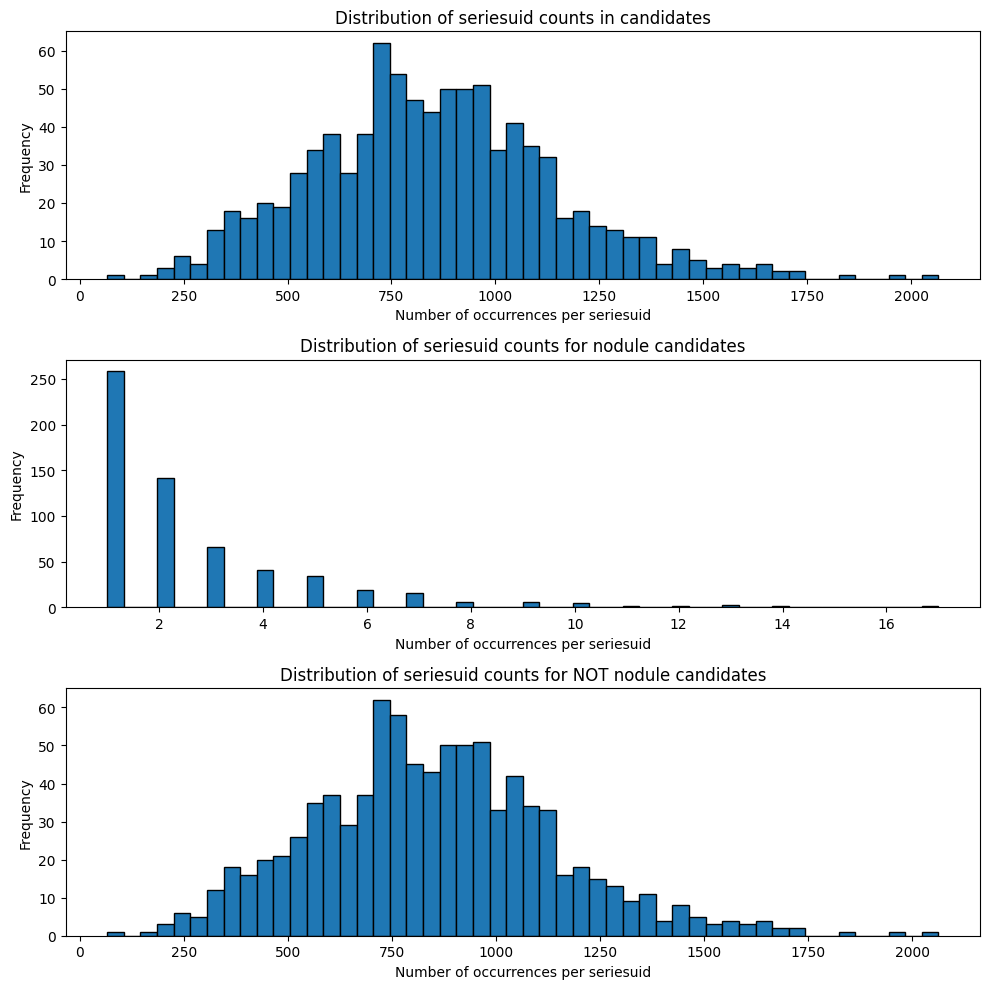

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

uid_counts = candidates["seriesuid"].value_counts()
ax1.hist(uid_counts, bins=50, edgecolor="black")
ax1.set_xlabel("Number of occurrences per seriesuid")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of seriesuid counts in candidates")

is_nodule_candidates = candidates[candidates["class"] == 1]

seriesuid_counts = is_nodule_candidates["seriesuid"].value_counts()
ax2.hist(seriesuid_counts, bins=50, edgecolor="black")
ax2.set_xlabel("Number of occurrences per seriesuid")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of seriesuid counts for nodule candidates")

not_nodule_candidates = candidates[candidates["class"] == 0]

seriesuid_counts = not_nodule_candidates["seriesuid"].value_counts()
ax3.hist(seriesuid_counts, bins=50, edgecolor="black")
ax3.set_xlabel("Number of occurrences per seriesuid")
ax3.set_ylabel("Frequency")
ax3.set_title("Distribution of seriesuid counts for NOT nodule candidates")

plt.tight_layout()
plt.show()

## Annotation file exploration

The `annotations_with_malignancy.csv` file contains information about the nodules that have been annotated by radiologists. It only contains information about nodules that have been annotated as malignant or benign.

### The Data

Dataset contains 1182 rows. 804 of them are marked as benign and 378 are marked as malignant.

The columns in the `annotations_with_malignancy.csv` file are as follows:

- `seriesuid`: The unique identifier for the CT scan in which the nodule was found.
- `coordX`, `coordY`, `coordZ`: The x, y, and z coordinates of the candidate nodule in the CT scan.
- `diameter_mm`: The diameter of the nodule in millimeters.
- `is_malignant`: Whether the nodule is malignant. 0 = benign, 1 = malignant.

the rest of the columns are not relevant for our analysis.

### Is Malignant Distribution

From the class distribution, we can see that the dataset is imbalanced. We have 804 benign nodules and 378 malignant nodules. This is a ratio of 2:1. This is a imbalance and we will need to address this when we build our model.

### Series UIDs

The `seriesuid` column contains the unique identifier for the CT scan it relates to. We have 600 unique series UIDs in the dataset.

Each CT scam has multiple annotations. It's approximately 1.3 annotations per CT scan.

In [52]:
annotations_malignancy_path = settings.DATA_DIR / "annotations_with_malignancy.csv"
annotations_malignancy = pd.read_csv(filepath_or_buffer=annotations_malignancy_path)
annotations_malignancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seriesuid          1182 non-null   object 
 1   coord_x            1182 non-null   float64
 2   coord_y            1182 non-null   float64
 3   coord_z            1182 non-null   float64
 4   diameter_mm        1182 non-null   float64
 5   is_malignant       1182 non-null   bool   
 6   malignant_details  1182 non-null   object 
 7   bboxLowX           1182 non-null   float64
 8   bboxLowY           1182 non-null   float64
 9   bboxLowZ           1182 non-null   float64
 10  bboxHighX          1182 non-null   float64
 11  bboxHighY          1182 non-null   float64
 12  bboxHighZ          1182 non-null   float64
 13  len_mal_details    1182 non-null   int64  
dtypes: bool(1), float64(10), int64(1), object(2)
memory usage: 121.3+ KB


In [53]:
annotations_malignancy.head()

,seriesuid,coord_x,coord_y,coord_z,diameter_mm,is_malignant,malignant_details,bboxLowX,bboxLowY,bboxLowZ,bboxHighX,bboxHighY,bboxHighZ,len_mal_details
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,True,"[4, 2, 4, 2]",-131.896480,-178.259761,-299.800004,-125.451167,-172.458980,-296.200004,4
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...,-69.175741,218.052625,-668.501273,4.441200,False,"[3, 2, 3]",-71.815939,215.709820,-670.900024,-66.722189,220.803570,-666.900024,3
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-67.459503,-247.744211,-211.095340,7.744222,True,"[5, 3, 4]",-73.027344,-253.847656,-213.100004,-61.074219,-242.558594,-209.500004,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-97.690876,-134.068054,-187.094883,6.690036,False,"[3, 3, 3]",-102.910156,-137.636719,-189.700005,-92.949219,-130.332031,-186.100005,3
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414...,69.529141,87.036153,-149.190113,10.824515,False,"[3, 3, 5, 2]",63.731247,80.468750,-154.000000,76.231247,93.750000,-144.000000,4


In [54]:
annotations_malignancy["is_malignant"].value_counts()

is_malignant
False    804
True     378
Name: count, dtype: int64

In [55]:
n_annotations_malignancy = len(annotations_malignancy)
n_unique_annotations_malignancy_seriesuids = len(
    annotations_malignancy.seriesuid.unique()
)
print(
    f"Annotations with malignancy dataframe has {n_annotations_malignancy} rows and {n_unique_annotations_malignancy_seriesuids} unique series uid values."
)

Annotations with malignancy dataframe has 1182 rows and 600 unique series uid values.


In [56]:
series_uid_values_count = annotations_malignancy["seriesuid"].value_counts()
n_same_seriesuid_mean_for_annotations_malignancy = series_uid_values_count.mean()
print(
    f"For {len(annotations_malignancy)} number of annotations with malignancy, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_annotations_malignancy:.2f}."
)
series_uid_values_count

For 1182 number of annotations with malignancy, the average number of rows with same seriesuid is 1.97.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518    12
1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630     9
1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842     9
                                                                    ..
1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684     1
1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302     1
Name: count, Length: 600, dtype: int64

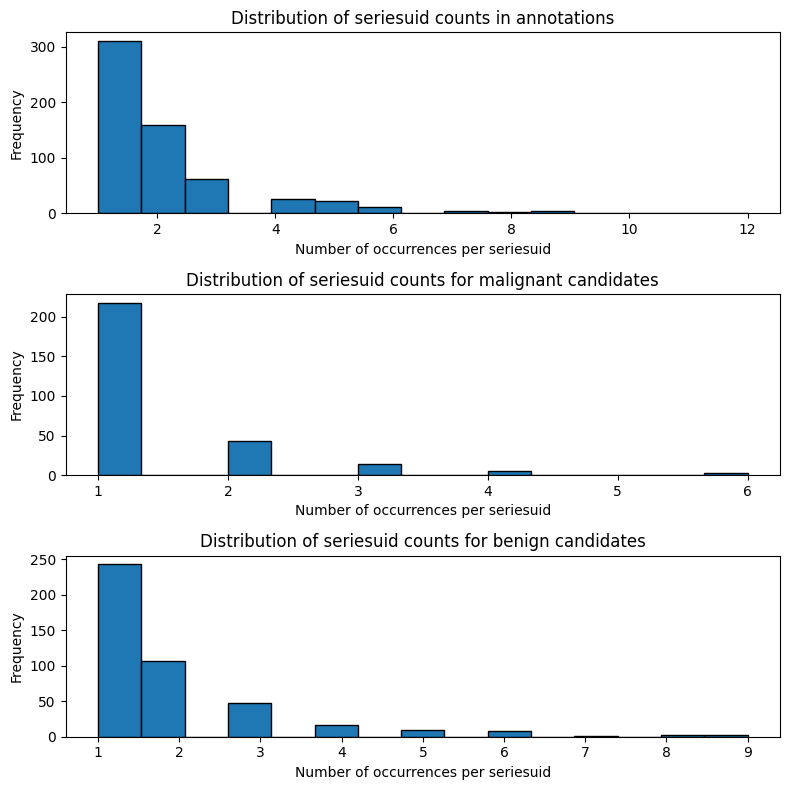

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

uid_counts = annotations_malignancy["seriesuid"].value_counts()
ax1.hist(uid_counts, bins=15, edgecolor="black")
ax1.set_xlabel("Number of occurrences per seriesuid")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of seriesuid counts in annotations")

malignant_annotations = annotations_malignancy[
    annotations_malignancy["is_malignant"] == True  # noqa: E712
]

seriesuid_counts = malignant_annotations["seriesuid"].value_counts()
ax2.hist(seriesuid_counts, bins=15, edgecolor="black")
ax2.set_xlabel("Number of occurrences per seriesuid")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of seriesuid counts for malignant ca§ndidates")

benign_annotations = annotations_malignancy[
    annotations_malignancy["is_malignant"] == False  # noqa: E712
]

seriesuid_counts = benign_annotations["seriesuid"].value_counts()
ax3.hist(seriesuid_counts, bins=15, edgecolor="black")
ax3.set_xlabel("Number of occurrences per seriesuid")
ax3.set_ylabel("Frequency")
ax3.set_title("Distribution of seriesuid counts for benign candidates")

plt.tight_layout()
plt.show()

In [58]:
diameter_col = annotations_malignancy["diameter_mm"]
diameter_col.describe()

count    1182.000000
mean        8.294700
std         4.755361
min         3.253443
25%         5.106208
50%         6.424177
75%         9.682801
max        32.270030
Name: diameter_mm, dtype: float64

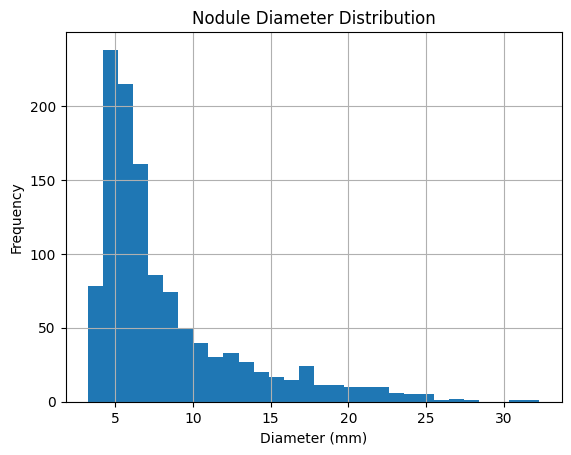

In [59]:
annotations_malignancy["diameter_mm"].hist(bins=30)
plt.title("Nodule Diameter Distribution")
plt.xlabel("Diameter (mm)")
plt.ylabel("Frequency")
plt.show()

# Concat Annotations and Candidates

From previous two dataframes, we can see they both contain complementary data. We will merge them into one dataframe to have all information in one place. 

We will do this by:

1) Dropping all rows marked as nodules from candidates dataframe. We would not be able to determine if they are malignant or benign. There might also be a lot of duplicates between candidates and annotations because they came form same CTs scan More in chapter **Candidate Nodules vs. Annotated Nodules**.
2) Creating new class column that will be 0 for malignant, 1 for benign and 2 for candidates that are not nodules.
3) Setting diameter_mm to 0 for candidates that are not nodules. This should indicate how large the nodule is and because they are not nodules they can be set to 0.
4) Merging the two dataframes on `seriesuid`, `diameter_mm`, `class`, `coord_x`, `coord_y`, `coord_z` columns. In the process, we also rename make them consistent with python naming conventions and consistent across dataframes.


## Candidate Nodules vs. Annotated Nodules

Looking at nodules from annotations and candidates, there are 1557 candidates and 1182 annotations. This means that there are 375 candidates that are not in the annotations.

When removing nodules form candidates dataframe, there will definitely be loss  of these at least 375 nodules. That is not good when the dataset is so imbalanced. These nodules can't be used for classifying malignant nodules but they can be used for classifying nodules vs. non-nodules. It's reasonable to think about creating separate dataset for nodule classificaation containing these nodules.

Even bigger problem is that the rest of the nodules might not be the same too. Code below concatinates annotation and candidate nodules and then checks if there are any duplicates. it first changes type of coordinates form float to int for easier comparison. In this case, there were only 296 duplicates. 

I also tried to replace last digit with zero on top of int conversion. In this case, there were 1221 duplicate. This is more than entire annotation dataset. This means that this showed potential duplicate inside candidates dataset. However, this operation is so drastic that it might not be reliable.

### Conclusion

For now, only nodules form annotations dataset will be used. If there will be big problem with overfitting, we can consider adding nodules from candidates dataset. But there must be more analysis done to ensure that they are not duplicates.

In [60]:
annotations_malignancy.head()

,seriesuid,coord_x,coord_y,coord_z,diameter_mm,is_malignant,malignant_details,bboxLowX,bboxLowY,bboxLowZ,bboxHighX,bboxHighY,bboxHighZ,len_mal_details
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,True,"[4, 2, 4, 2]",-131.896480,-178.259761,-299.800004,-125.451167,-172.458980,-296.200004,4
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...,-69.175741,218.052625,-668.501273,4.441200,False,"[3, 2, 3]",-71.815939,215.709820,-670.900024,-66.722189,220.803570,-666.900024,3
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-67.459503,-247.744211,-211.095340,7.744222,True,"[5, 3, 4]",-73.027344,-253.847656,-213.100004,-61.074219,-242.558594,-209.500004,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,-97.690876,-134.068054,-187.094883,6.690036,False,"[3, 3, 3]",-102.910156,-137.636719,-189.700005,-92.949219,-130.332031,-186.100005,3
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414...,69.529141,87.036153,-149.190113,10.824515,False,"[3, 3, 5, 2]",63.731247,80.468750,-154.000000,76.231247,93.750000,-144.000000,4


In [61]:
candidates_nodules = candidates.copy()
candidates_nodules = candidates[candidates["class"] == 1]
candidates_nodules_coords = candidates_nodules[["coordX", "coordY", "coordZ"]]
candidates_nodules_coords.rename(
    columns={"coordX": "coord_x", "coordY": "coord_y", "coordZ": "coord_z"},
    inplace=True,
)
candidates_nodules_coords

/var/folders/2j/mfpmmx2j1pn212m7_ltydq0h0000gn/T/ipykernel_93475/1531181280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_nodules_coords.rename(


,coord_x,coord_y,coord_z
436,104.083933,-211.755826,-227.017987
1009,-128.982091,-175.176790,-298.510193
2053,69.974375,-141.066875,876.777280
3633,1.790000,166.340000,-408.880000
3707,1.859783,172.221534,-405.366447
...,...,...,...
754090,-29.720000,24.620000,-156.010000
754622,42.895122,74.251037,-200.625978
754755,-28.685000,32.690000,-164.835000
754947,-23.719297,31.714489,-156.172233


In [62]:
annotations_malignancy_nodules_coords = annotations_malignancy[
    ["coord_x", "coord_y", "coord_z"]
]
annotations_malignancy_nodules_coords

,coord_x,coord_y,coord_z
0,-128.699421,-175.319272,-298.387506
1,-69.175741,218.052625,-668.501273
2,-67.459503,-247.744211,-211.095340
3,-97.690876,-134.068054,-187.094883
4,69.529141,87.036153,-149.190113
...,...,...,...
1177,-57.725518,73.779494,-147.415580
1178,-72.287990,-77.481968,-160.486254
1179,96.625954,-46.154823,-88.229432
1180,33.104795,-63.116434,-108.725571


In [63]:
combined_nodules_coords = pd.concat(
    [candidates_nodules_coords, annotations_malignancy_nodules_coords]
)
combined_nodules_coords.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2739 entries, 436 to 1181
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  2739 non-null   float64
 1   coord_y  2739 non-null   float64
 2   coord_z  2739 non-null   float64
dtypes: float64(3)
memory usage: 85.6 KB


In [64]:
dropped_coords = combined_nodules_coords.drop_duplicates()

(
    f"Number of rows ({len(combined_nodules_coords)}) is the same when we drop duplicates "
    f"({len(dropped_coords)}) so our dataframe does not have any duplicates. Thus, "
    "we can use seriesuid and center coordinates to uniquely identify rows."
)

'Number of rows (2739) is the same when we drop duplicates (2739) so our dataframe does not have any duplicates. Thus, we can use seriesuid and center coordinates to uniquely identify rows.'

In [65]:
combined_nodules_int_coords = combined_nodules_coords.astype(int)
combined_nodules_int_coords.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2739 entries, 436 to 1181
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   coord_x  2739 non-null   int64
 1   coord_y  2739 non-null   int64
 2   coord_z  2739 non-null   int64
dtypes: int64(3)
memory usage: 85.6 KB


In [66]:
dropped_coords = combined_nodules_int_coords.drop_duplicates()

(
    f"Number of rows ({len(combined_nodules_int_coords)}) is NOT the same when we drop duplicates "
    f"({len(dropped_coords)}) so our dataframe does have any duplicates. "
    f"That is {len(combined_nodules_int_coords) - len(dropped_coords)} duplicates."
)

'Number of rows (2739) is NOT the same when we drop duplicates (2443) so our dataframe does have any duplicates. That is 296 duplicates.'

In [67]:
def set_last_digit_to_zero(x: int) -> int:
    return int(x / 10) * 10


combined_nodules_int_zeroed_coords = combined_nodules_int_coords.copy()
combined_nodules_int_zeroed_coords = combined_nodules_int_zeroed_coords.map(
    set_last_digit_to_zero
)
combined_nodules_int_zeroed_coords

,coord_x,coord_y,coord_z
436,100,-210,-220
1009,-120,-170,-290
2053,60,-140,870
3633,0,160,-400
3707,0,170,-400
...,...,...,...
1177,-50,70,-140
1178,-70,-70,-160
1179,90,-40,-80
1180,30,-60,-100


In [68]:
dropped_coords = combined_nodules_int_zeroed_coords.drop_duplicates()

(
    f"Number of rows ({len(combined_nodules_int_zeroed_coords)}) is NOT the same when we drop duplicates "
    f"({len(dropped_coords)}) so our dataframe does have any duplicates. "
    f"That is {len(combined_nodules_int_zeroed_coords) - len(dropped_coords)} duplicates."
)

'Number of rows (2739) is NOT the same when we drop duplicates (1518) so our dataframe does have any duplicates. That is 1221 duplicates.'

## Concatenated Dataframe

In [69]:
not_nodule_candidates = candidates[candidates["class"] == 0].copy()
not_nodule_candidates["diameter_mm"] = 0.0
not_nodule_candidates["class"] = enums.CandidateClass.NOT_NODULE
not_nodule_candidates.rename(
    columns={"coordX": "coord_x", "coordY": "coord_y", "coordZ": "coord_z"},
    inplace=True,
)
not_nodule_candidates

,seriesuid,coord_x,coord_y,coord_z,class,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,2,0.0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,2,0.0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,2,0.0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,2,0.0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,2,0.0
...,...,...,...,...,...,...
754970,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-33.400000,-64.200000,-115.560000,2,0.0
754971,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,56.236359,70.352400,-203.446236,2,0.0
754972,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-97.104221,55.738289,-203.879785,2,0.0
754973,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-65.470000,59.670000,-136.370000,2,0.0


In [70]:
not_nodule_candidates.value_counts("class")

class
2    753418
Name: count, dtype: int64

In [71]:
nodule_annotations_malignancy = annotations_malignancy.copy()
nodule_annotations_malignancy["class"] = enums.CandidateClass.BENIGN
nodule_annotations_malignancy.loc[
    nodule_annotations_malignancy["is_malignant"] == True, "class"  # noqa: E712
] = enums.CandidateClass.MALIGNANT
nodule_annotations_malignancy = nodule_annotations_malignancy[
    [
        "seriesuid",
        "diameter_mm",
        "class",
        "coord_x",
        "coord_y",
        "coord_z",
    ]
]
nodule_annotations_malignancy

,seriesuid,diameter_mm,class,coord_x,coord_y,coord_z
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,5.651471,0,-128.699421,-175.319272,-298.387506
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735...,4.441200,1,-69.175741,218.052625,-668.501273
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,7.744222,0,-67.459503,-247.744211,-211.095340
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002...,6.690036,1,-97.690876,-134.068054,-187.094883
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414...,10.824515,1,69.529141,87.036153,-149.190113
...,...,...,...,...,...,...
1177,1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686...,11.801797,1,-57.725518,73.779494,-147.415580
1178,1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686...,4.087102,1,-72.287990,-77.481968,-160.486254
1179,1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686...,6.326436,1,96.625954,-46.154823,-88.229432
1180,1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262...,10.759349,1,33.104795,-63.116434,-108.725571


In [72]:
nodule_annotations_malignancy.value_counts("class")

class
1    804
0    378
Name: count, dtype: int64

In [73]:
complete_candidates = pd.concat([not_nodule_candidates, nodule_annotations_malignancy])
complete_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 754600 entries, 0 to 1181
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   seriesuid    754600 non-null  object 
 1   coord_x      754600 non-null  float64
 2   coord_y      754600 non-null  float64
 3   coord_z      754600 non-null  float64
 4   class        754600 non-null  int64  
 5   diameter_mm  754600 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.3+ MB


In [74]:
complete_candidates.head()

,seriesuid,coord_x,coord_y,coord_z,class,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,2,0.0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,2,0.0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,2,0.0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,2,0.0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,2,0.0


In [75]:
for status in enums.CandidateClass:
    print(f"{status.name} = {status.value}")

complete_candidates.value_counts("class")

MALIGNANT = 0
BENIGN = 1
NOT_NODULE = 2


class
2    753418
1       804
0       378
Name: count, dtype: int64

In [76]:
diameter_col = complete_candidates["diameter_mm"]
diameter_col.describe()

count    754600.000000
mean          0.012993
std           0.378145
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.270030
Name: diameter_mm, dtype: float64

In [77]:
series_uid_values_count = complete_candidates.value_counts("seriesuid")
n_same_seriesuid_mean_for_complete_candidates = series_uid_values_count.mean()
print(
    f"For {len(complete_candidates)} number of complete candidates, the average number "
    f"of rows with same seriesuid is {n_same_seriesuid_mean_for_complete_candidates:.2f}."
)
series_uid_values_count

For 754600 number of complete candidates, the average number of rows with same seriesuid is 849.77.


seriesuid
1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822    2064
1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586    1972
1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295    1825
1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856    1723
1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687    1713
                                                                    ... 
1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320     215
1.3.6.1.4.1.14519.5.2.1.6279.6001.333319057944372470283038483725     208
1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630     207
1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559     185
1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938      66
Name: count, Length: 888, dtype: int64

In [78]:
dropped_candidates = complete_candidates[
    ["seriesuid", "coord_x", "coord_y", "coord_z"]
].drop_duplicates()

(
    f"Number of rows ({len(complete_candidates)}) is the same when we drop duplicates "
    f"({len(dropped_candidates)}) so our dataframe does not have any duplicates. Thus, "
    "we can use seriesuid and center coordinates to uniquely identify rows."
)

'Number of rows (754600) is the same when we drop duplicates (754600) so our dataframe does not have any duplicates. Thus, we can use seriesuid and center coordinates to uniquely identify rows.'

In [79]:
complete_candidates_path = settings.DATA_DIR / "complete_candidates.csv"
complete_candidates.to_csv(complete_candidates_path, index=False)